In [ ]:
import cv2
import numpy as np
import torchvision.transforms as transforms

from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

In [ ]:
#autopad from YOLOV5m
import warnings
import math
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

In [ ]:
#For custom backbone
class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

In [ ]:
#For custom backbone
class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            #nn.ELU(),
            nn.Linear(channel // reduction, channel),
            Hswish())

    def forward(self, x):
        #print("###########Inside SE#############")
        #print("shPPPPPe x",x.shape)
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        #print("shapppppeee y",y.shape)
        y = y.view(b, c)
        #print("$$$$Y after View$$$$$$",y.shape)
        y = self.fc(y).view(b, c, 1, 1)
        #print("X and Y",x.shape,y.shape)

        return x * y

In [ ]:
#Conv of YOLOV5m
class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


In [ ]:
# Additional from YOLOV5 common.py for safety
class DWConv(Conv):
    # Depth-wise convolution
    def __init__(self, c1, c2, k=1, s=1, d=1, act=True):  # ch_in, ch_out, kernel, stride, dilation, activation
        super().__init__(c1, c2, k, s, g=math.gcd(c1, c2), d=d, act=act)


class DWConvTranspose2d(nn.ConvTranspose2d):
    # Depth-wise transpose convolution
    def __init__(self, c1, c2, k=1, s=1, p1=0, p2=0):  # ch_in, ch_out, kernel, stride, padding, padding_out
        super().__init__(c1, c2, k, s, p1, p2, groups=math.gcd(c1, c2))


class TransformerLayer(nn.Module):
    # Transformer layer https://arxiv.org/abs/2010.11929 (LayerNorm layers removed for better performance)
    def __init__(self, c, num_heads):
        super().__init__()
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.ma = nn.MultiheadAttention(embed_dim=c, num_heads=num_heads)
        self.fc1 = nn.Linear(c, c, bias=False)
        self.fc2 = nn.Linear(c, c, bias=False)

    def forward(self, x):
        x = self.ma(self.q(x), self.k(x), self.v(x))[0] + x
        x = self.fc2(self.fc1(x)) + x
        return x


class TransformerBlock(nn.Module):
    # Vision Transformer https://arxiv.org/abs/2010.11929
    def __init__(self, c1, c2, num_heads, num_layers):
        super().__init__()
        self.conv = None
        if c1 != c2:
            self.conv = Conv(c1, c2)
        self.linear = nn.Linear(c2, c2)  # learnable position embedding
        self.tr = nn.Sequential(*(TransformerLayer(c2, num_heads) for _ in range(num_layers)))
        self.c2 = c2

    def forward(self, x):
        if self.conv is not None:
            x = self.conv(x)
        b, _, w, h = x.shape
        p = x.flatten(2).permute(2, 0, 1)
        return self.tr(p + self.linear(p)).permute(1, 2, 0).reshape(b, self.c2, w, h)


class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))


class CrossConv(nn.Module):
    # Cross Convolution Downsample
    def __init__(self, c1, c2, k=3, s=1, g=1, e=1.0, shortcut=False):
        # ch_in, ch_out, kernel, stride, groups, expansion, shortcut
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, (1, k), (1, s))
        self.cv2 = Conv(c_, c2, (k, 1), (s, 1), g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


In [ ]:
#C3 from YOLOV5m
class C3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


In [ ]:
# Additional from YOLOV5m for safety
class C3x(C3):
    # C3 module with cross-convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = nn.Sequential(*(CrossConv(c_, c_, 3, 1, g, 1.0, shortcut) for _ in range(n)))


class C3TR(C3):
    # C3 module with TransformerBlock()
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = TransformerBlock(c_, c_, 4, n)


class C3SPP(C3):
    # C3 module with SPP()
    def __init__(self, c1, c2, k=(5, 9, 13), n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = SPP(c_, c_, k)


class C3Ghost(C3):
    # C3 module with GhostBottleneck()
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)  # hidden channels
        self.m = nn.Sequential(*(GhostBottleneck(c_, c_) for _ in range(n)))


class SPP(nn.Module):
    # Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))


In [ ]:
#SPPF from YOLOV5m
class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

In [ ]:
# Additional for safety
class Focus(nn.Module):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, g, act=act)
        # self.contract = Contract(gain=2)

    def forward(self, x):  # x(b,c,w,h) -> y(b,4c,w/2,h/2)
        return self.conv(torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1))
        # return self.conv(self.contract(x))


class GhostConv(nn.Module):
    # Ghost Convolution https://github.com/huawei-noah/ghostnet
    def __init__(self, c1, c2, k=1, s=1, g=1, act=True):  # ch_in, ch_out, kernel, stride, groups
        super().__init__()
        c_ = c2 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
        self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)

    def forward(self, x):
        y = self.cv1(x)
        return torch.cat((y, self.cv2(y)), 1)


class GhostBottleneck(nn.Module):
    # Ghost Bottleneck https://github.com/huawei-noah/ghostnet
    def __init__(self, c1, c2, k=3, s=1):  # ch_in, ch_out, kernel, stride
        super().__init__()
        c_ = c2 // 2
        self.conv = nn.Sequential(
            GhostConv(c1, c_, 1, 1),  # pw
            DWConv(c_, c_, k, s, act=False) if s == 2 else nn.Identity(),  # dw
            GhostConv(c_, c2, 1, 1, act=False))  # pw-linear
        self.shortcut = nn.Sequential(DWConv(c1, c1, k, s, act=False), Conv(c1, c2, 1, 1,
                                                                            act=False)) if s == 2 else nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)


class Contract(nn.Module):
    # Contract width-height into channels, i.e. x(1,64,80,80) to x(1,256,40,40)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert (h / s == 0) and (W / s == 0), 'Indivisible gain'
        s = self.gain
        x = x.view(b, c, h // s, s, w // s, s)  # x(1,64,40,2,40,2)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # x(1,2,2,64,40,40)
        return x.view(b, c * s * s, h // s, w // s)  # x(1,256,40,40)


class Expand(nn.Module):
    # Expand channels into width-height, i.e. x(1,64,80,80) to x(1,16,160,160)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert C / s ** 2 == 0, 'Indivisible gain'
        s = self.gain
        x = x.view(b, s, s, c // s ** 2, h, w)  # x(1,2,2,16,80,80)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # x(1,16,80,2,80,2)
        return x.view(b, c // s ** 2, h * s, w * s)  # x(1,16,160,160)


class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)

In [ ]:
model = torch.load('encodernew (1).pt')

<ipython-input-11-a85c20c62fde>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('encodernew (1).pt')


In [ ]:
print(type(model))

<class 'torch.nn.modules.container.Sequential'>


In [ ]:
from torchsummary import summary

In [ ]:
#summary(model, input_size=(3, 640, 640))
#print(model)

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

In [ ]:
# Load the image
image_path = "m5.JPG"
image = Image.open(image_path)

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor()          # Convert the image to a tensor
])

In [ ]:
image_tensor = preprocess(image)

In [ ]:
image_tensor = image_tensor.unsqueeze(0)

In [ ]:
model.eval()

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (1): Conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (2): SELayer(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=128, bias=True)
      (3): Hswish(
        (relu): ReLU6(inplace=True)
      )
    )
  )
  (3): C3(
    (cv1): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU()
    )
    (cv2): Conv(
 

In [ ]:
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image_tensor)

In [ ]:
print(image_tensor.shape)

torch.Size([1, 3, 1200, 1600])


In [ ]:
print(output.shape)

torch.Size([1, 1024, 19, 25])


In [ ]:
print(type(output))

<class 'torch.Tensor'>


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
feature_map = output.squeeze(0)
print(feature_map.shape)

torch.Size([1024, 19, 25])


In [ ]:
output_np = output.cpu().numpy()

In [ ]:
feature_map_np = feature_map.cpu().numpy()

In [ ]:
num_channels_to_plot = 4
selected_channels = feature_map_np[:num_channels_to_plot, :, :]

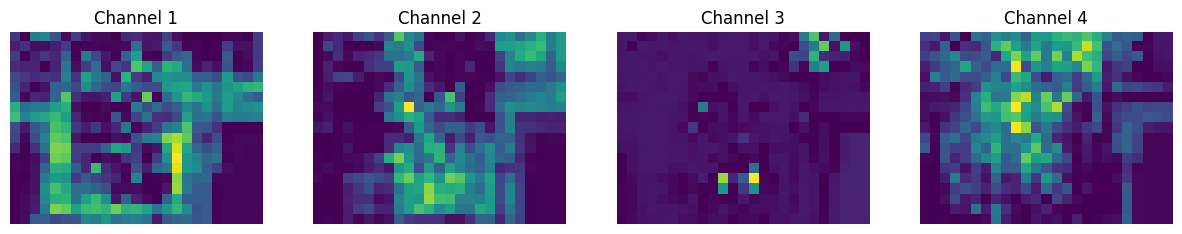

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(num_channels_to_plot):
    plt.subplot(1, num_channels_to_plot, i + 1)
    plt.imshow(selected_channels[i], cmap='viridis')
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.show()

In [ ]:
import torch
import torch.nn.functional as F

# Upsample to the target size (1, 1024, 1200, 1600)
upsampled_output = F.interpolate(output, size=(1200, 1600), mode='bilinear', align_corners=False)

print(upsampled_output.shape)  # Output should be torch.Size([1, 1024, 1200, 1600])

torch.Size([1, 1024, 1200, 1600])


In [ ]:
from skimage import io
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

In [ ]:
upsampled_output_np = upsampled_output.cpu().numpy()
image_np = image_tensor.cpu().numpy()

In [ ]:
upsampled_output_np.shape

(1, 1024, 1200, 1600)

In [ ]:
from torchvision import transforms
grayscale = transforms.Grayscale()
grayscale_image = (grayscale(image_tensor.squeeze(0))).unsqueeze(0)
grayscale_image_np = grayscale_image.cpu().numpy()
grayscale_image_np_flattened = grayscale_image_np.ravel()

In [ ]:
mutual_information = []
for i in range(upsampled_output_np.shape[1]):
  feature_map_flattened = (upsampled_output_np[:,i,:,:]).ravel()
  mutual_information.append(mutual_info_score(grayscale_image_np_flattened, feature_map_flattened))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

In [ ]:
len(mutual_information)

1024

In [ ]:
final_output = np.zeros((1, 1200, 1600))

In [ ]:
for i in range(upsampled_output_np.shape[1]):
    final_output = final_output + (mutual_information[i] * upsampled_output_np[:,i,:,:])

In [ ]:
final_output.shape

(1, 1200, 1600)

In [ ]:
final_output_resized = np.squeeze(final_output)
final_output_resized.shape

(1200, 1600)

<function matplotlib.pyplot.show(close=None, block=None)>

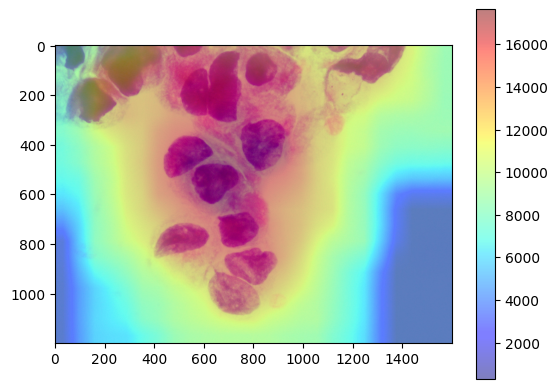

In [ ]:
plt.imshow(image)
plt.imshow(final_output_resized, cmap = 'jet', alpha = 0.5)
plt.colorbar()
plt.show